# Local Web Research Agent w/ Llama 3 8b

### [Llama 3 Release](https://llama.meta.com/llama3/)

### [Ollama Llama 3 Model](https://ollama.com/library/llama3)
---

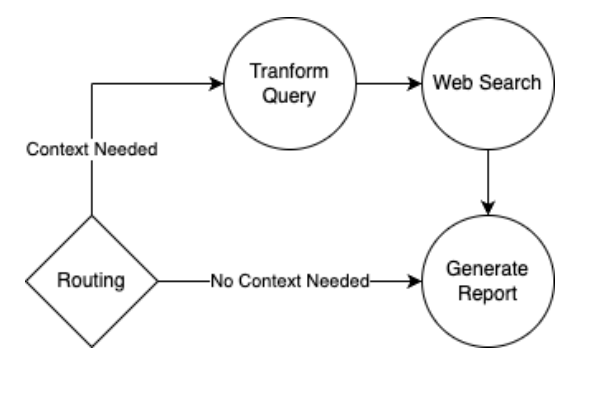

---
[Llama 3 Prompt Format](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/)

### Special Tokens used with Meta Llama 3
* **<|begin_of_text|>**: This is equivalent to the BOS token
* **<|eot_id|>**: This signifies the end of the message in a turn.
* **<|start_header_id|>{role}<|end_header_id|>**: These tokens enclose the role for a particular message. The possible roles can be: system, user, assistant.
* **<|end_of_text|>**: This is equivalent to the EOS token. On generating this token, Llama 3 will cease to generate more tokens.
A prompt should contain a single system message, can contain multiple alternating user and assistant messages, and always ends with the last user message followed by the assistant header.

In [ ]:
# Displaying final output format
from IPython.display import display, Markdown, Latex
# LangChain Dependencies
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langgraph.graph import END, StateGraph
# For State Graph
from typing_extensions import TypedDict
import os

In [2]:
# Environment Variables
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ["LANGCHAIN_PROJECT"] = "L3 Research Agent"

In [3]:
# Defining LLM
local_llm = 'llama3'
llama3 = ChatOllama(model=local_llm, temperature=0)
llama3_json = ChatOllama(model=local_llm, format='json', temperature=0)

In [4]:
# Web Search Tool

wrapper = DuckDuckGoSearchAPIWrapper(max_results=25)
web_search_tool = DuckDuckGoSearchRun(api_wrapper=wrapper)

# Test Run
# resp = web_search_tool.invoke("home depot news")
# resp

In [ ]:
# Generation Prompt

generate_prompt = PromptTemplate(
    template="""

    <|begin_of_text|>

    <|start_header_id|>system<|end_header_id|>

    You are an AI assistant for Research Question Tasks, that synthesizes web search results.
    Strictly use the following pieces of web search context to answer the question. If you don't know the answer, just say that you don't know.
    keep the answer concise, but provide all of the details you can in the form of a research report.
    Only make direct references to material if provided in the context.

    <|eot_id|>

    <|start_header_id|>user<|end_header_id|>

    Question: {question}
    Web Search Context: {context}
    Answer:

    <|eot_id|>

    <|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "context"],
)

# Chain
generate_chain = generate_prompt | llama3 | StrOutputParser()

# Test Run
# question = "How are you?"
# context = ""
# generation = generate_chain.invoke({"context": context, "question": question})
# print(generation)

In [ ]:
# Router

router_prompt = PromptTemplate(
    template="""

    <|begin_of_text|>

    <|start_header_id|>system<|end_header_id|>

    You are an expert at routing a user question to either the generation stage or web search.
    Use the web search for questions that require more context for a better answer, or recent events.
    Otherwise, you can skip and go straight to the generation phase to respond.
    You do not need to be stringent with the keywords in the question related to these topics.
    Give a binary choice 'web_search' or 'generate' based on the question.
    Return the JSON with a single key 'choice' with no premable or explanation.

    Question to route: {question}

    <|eot_id|>

    <|start_header_id|>assistant<|end_header_id|>

    """,
    input_variables=["question"],
)

# Chain
question_router = router_prompt | llama3_json | JsonOutputParser()

# Test Run
question = "What's up?"
print(question_router.invoke({"question": question}))

{'choice': 'generate'}


In [ ]:
# Query Transformation

query_prompt = PromptTemplate(
    template="""

    <|begin_of_text|>

    <|start_header_id|>system<|end_header_id|>

    You are an expert at crafting web search queries for research questions.
    More often than not, a user will ask a basic question that they wish to learn more about, however it might not be in the best format.
    Reword their query to be the most effective web search string possible.
    Return the JSON with a single key 'query' with no premable or explanation.

    Question to transform: {question}

    <|eot_id|>

    <|start_header_id|>assistant<|end_header_id|>

    """,
    input_variables=["question"],
)

# Chain
query_chain = query_prompt | llama3_json | JsonOutputParser()

# Test Run
question = "What's happened recently with Macom?"
print(query_chain.invoke({"question": question}))

{'query': 'Macom recent news'}


In [ ]:
# Graph State
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search_query: revised question for web search
        context: web_search result
    """
    question : str
    generation : str
    search_query : str
    context : str

# Node - Generate

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    print("Step: Generating Final Response")
    question = state["question"]
    context = state["context"]

    # Answer Generation
    generation = generate_chain.invoke({"context": context, "question": question})
    return {"generation": generation}

# Node - Query Transformation

def transform_query(state):
    """
    Transform user question to web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended search query
    """

    print("Step: Optimizing Query for Web Search")
    question = state['question']
    gen_query = query_chain.invoke({"question": question})
    search_query = gen_query["query"]
    return {"search_query": search_query}


# Node - Web Search

def web_search(state):
    """
    Web search based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to context
    """

    search_query = state['search_query']
    print(f'Step: Searching the Web for: "{search_query}"')

    # Web search tool call
    search_result = web_search_tool.invoke(search_query)
    return {"context": search_result}


# Conditional Edge, Routing

def route_question(state):
    """
    route question to web search or generation.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("Step: Routing Query")
    question = state['question']
    output = question_router.invoke({"question": question})
    if output['choice'] == "web_search":
        print("Step: Routing Query to Web Search")
        return "websearch"
    elif output['choice'] == 'generate':
        print("Step: Routing Query to Generation")
        return "generate"

In [9]:
# Build the nodes
workflow = StateGraph(GraphState)
workflow.add_node("websearch", web_search)
workflow.add_node("transform_query", transform_query)
workflow.add_node("generate", generate)

# Build the edges
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "websearch")
workflow.add_edge("websearch", "generate")
workflow.add_edge("generate", END)

# Compile the workflow
local_agent = workflow.compile()

In [ ]:
from IPython.display import Image, display
display(Image(local_agent.get_graph().draw_mermaid_png()))

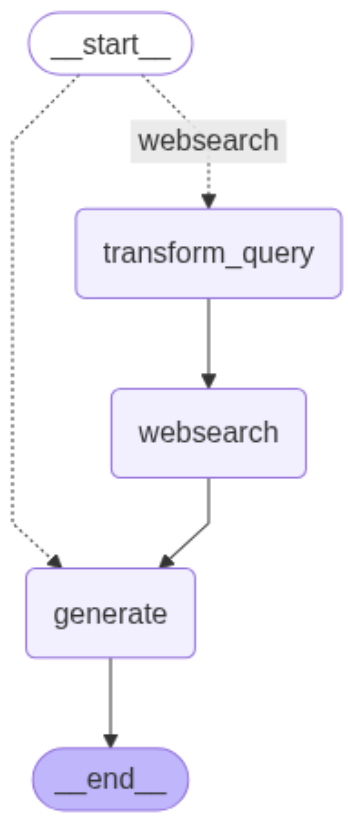

In [10]:
def run_agent(query):
    output = local_agent.invoke({"question": query})
    print("=======")
    display(Markdown(output["generation"]))

In [11]:
# Test it out!
run_agent("What's been up with Macom recently?")

Step: Routing Query
Step: Routing Query to Web Search
Step: Optimizing Query for Web Search
Step: Searching the Web for: "Macom recent news"
Step: Generating Final Response


Based on the provided web search context, it appears that MACOM Technology Solutions Holdings, Inc. (MACOM) has been involved in several recent developments and announcements.

In August 2023, MACOM announced that it had entered into a definitive agreement to acquire the radio frequency (RF) business of Wolfspeed, Inc. The acquisition was completed on December 2, 2023.

In May 2024, MACOM announced its financial results for its fiscal second quarter ended March 29, 2024. The company reported revenue of $181.2 million, an increase of 7.0% compared to the previous year.

Additionally, MACOM has been hosting live demonstrations of its products at industry events, including the Optical Fiber Communication Conference and Exhibition in March 2024.

It's worth noting that while MACOM has experienced a recent dip in revenue growth (-8.95% over the last twelve months as of Q2 2024), the company has shown quarterly revenue growth of 6.98% in Q2 2024, outperforming the industry's decline of 0.4%.

Overall, it appears that MACOM is focused on expanding its product portfolio and driving revenue growth through strategic acquisitions and product demonstrations.